In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [74]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [75]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      73


# Create datasets

## Position index

In [76]:
def addPositionIndex(data):
    data['positionIndex'] = 0

    x_pos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.35, 0.65, 0.35, 0.65]
    y_pos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8, 0.35, 0.35, 0.65, 0.65]

    for i in range(0, len(x_pos)):
        data.loc[(data['x_pos']==x_pos[i]) & (data['y_pos']==y_pos[i]), 'positionIndex']=i
    return data

data_trial = addPositionIndex(data_trial)

data_trial.loc[
    (data_trial['trial_type']=='eyetracking-calibration'), ['x_pos', 'y_pos', 'positionIndex']] \
    .drop_duplicates() \
    .sort_values(by='positionIndex')

,x_pos,y_pos,positionIndex
41,0.20,0.20,0
27,0.50,0.20,1
17,0.80,0.20,2
21,0.20,0.50,3
37,0.50,0.50,4
33,0.80,0.50,5
39,0.20,0.80,6
31,0.50,0.80,7
29,0.80,0.80,8
25,0.35,0.35,9


## data_et

In [77]:
def add_var_to_data_et(data_et, source_data, varName):
    if varName in data_et.columns: data_et=data_et.drop(columns=varName)
    data_et = data_et.merge(
        source_data.loc[:, ['run_id', 'trial_index', varName]], 
        on=['run_id', 'trial_index'], how='left')
    return data_et

data_et = add_var_to_data_et(data_et, data_trial, 'task_nr')
data_et = add_var_to_data_et(data_et, data_trial, 'chin')
data_et = add_var_to_data_et(data_et, data_trial, 'chinFirst')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_type')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration')
data_et = add_var_to_data_et(data_et, data_trial, 'trial_duration_exact')
data_et = add_var_to_data_et(data_et, data_trial, 'x_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'y_pos')
data_et = add_var_to_data_et(data_et, data_trial, 'window_width')
data_et = add_var_to_data_et(data_et, data_trial, 'window_height')

## data_trial

In [78]:
if 'glasses_binary' in data_trial.columns:
    data_trial = data_trial.drop(columns=['glasses_binary'])
data_trial = data_trial.merge(
    data_subject.loc[:, ['run_id', 'glasses_binary']],
    on='run_id',
    how='left'
)

## data_et_fix

In [79]:
data_et_fix = data_et.loc[
    (data_et['trial_type']=='eyetracking-fix-object') &
    (data_et['trial_duration']==5000) &
    (data_et['t_task']>1000),     :
]

## data_trial_fix

In [80]:
data_trial_fix = data_trial.loc[
    (data_trial['trial_type']=='eyetracking-fix-object') &
    (data_trial['trial_duration']==5000),     :
].drop(columns=[
    'trial_type', 'trial_duration', 
    'choiceTask_amountLeftFirst',
    'option_topLeft', 'option_bottomLeft',
    'option_topRight', 'option_bottomRight',
    'chosenAmount', 'chosenDelay']
      )

# Screening

## Not enough trials

In [81]:
NTrials = data_trial.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
46     125         15.0
56    2002        112.0
59    2011         32.0


In [82]:
temp = data_trial_fix.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_notEnoughTrials_fix = temp.loc[temp['trial_index']<131, 'run_id']
temp.loc[temp['trial_index']<131, :]

,run_id,trial_index
27,61,130.0
31,70,130.0


In [83]:
subjects_notEnoughTrials = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_notEnoughTrials_fix)
)
subjects_notEnoughTrials

[2002, 61, 70, 2011, 125]

## Not following intructions 

In [84]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin


In [85]:
subjects_noInstruction = data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    'run_id'
].reset_index(drop=True)

## High t_task

In [86]:
data_et_fix.loc[data_et_fix['t_task']>5500, :] \
    .groupby(['run_id'])['x'].count()

run_id
1.0       27
9.0       37
70.0      18
80.0      18
97.0      29
1021.0     2
2008.0     1
2012.0    28
Name: x, dtype: int64

In [87]:
data_trial_fix.loc[data_trial_fix['trial_duration_exact']>5500, :] \
    .groupby(['run_id', 'trial_index']).mean() \
    .reset_index() \
    .loc[:, ['run_id', 'trial_index', 'trial_duration_exact']]

,run_id,trial_index,trial_duration_exact
0,1,106.0,6337.0
1,1,109.0,6371.0
2,1,112.0,6296.0
3,1,115.0,6318.0
4,1,118.0,6310.0
...,...,...,...
101,2012,243.0,7092.0
102,2012,246.0,7230.0
103,2012,249.0,7122.0
104,2012,252.0,6075.0


## Not approved by prolific

In [88]:
data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    :
]

,run_id,birthyear,browliner,browser,browser_version,degree,device,ethnic,eyeliner,eyeshadow,...,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1


In [89]:
subjects_notApproved = data_subject.loc[
    ~data_subject['status'].isin(['APPROVED', 'NOTPROLIFIC']),
    'run_id'
]
subjects_notApproved

Series([], Name: run_id, dtype: int64)

# Cleaning

In [90]:
excludedSubjects = list(
    set(subjects_notEnoughTrials) | 
    set(subjects_noInstruction) |
    set(subjects_notApproved)
)
excludedSubjects

[2002, 125, 70, 2011, 61]

## data_subject variables

In [91]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

In [92]:
data_subject = data_subject.loc[~data_subject['run_id'].isin(excludedSubjects), :]
print(data_subject['run_id'].unique())

[   1  103  106  108   11  124  126  128   13  130  131   14   19   24
   25   28   30   32   36   37   38    4   41   42   43   45   47   49
    5   54   56   58   59    6   63   66   67    7   72   74   75   80
   81   83   85   88   90   91   92   93   94   96   97   98   99 1000
 1001 1011 1014 1015 1016 1017 1019 1002 1020 1021 1007 1009 1022 1024
 2012 2013 2009]


## Trial data

In [202]:
def cleanTrialData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_trial')
data_trial = cleanTrialData(data_trial)
print('\n data_trial_fix')
data_trial_fix = cleanTrialData(data_trial_fix)

data_trial
raw data: 29525
cleaned data: 29525

 data_trial_fix
raw data: 929
cleaned data: 929


## Eyetracking data
Exclude subjects, and trials with high duration

In [94]:
def cleanETData(data):
    print('raw data: ' + str(len(data)))
    data = data \
        .loc[~data['run_id'].isin(excludedSubjects), :] \
        .reset_index(drop=True)
    print('cleaned data: ' + str(len(data)))
    return data

print('data_et')
data_et = cleanETData(data_et)

print('\n data_et_fix')
data_et_fix = cleanETData(data_et_fix)
data_et_fix = data_et_fix.loc[
    data_et_fix['trial_duration_exact']<5000,
    :
]

data_et
raw data: 618566
cleaned data: 611463

 data_et_fix
raw data: 65042
cleaned data: 64392


# Offset

## Calculate on gaze point-level

In [95]:
data_trial.loc[
    data_trial['trial_type'].isin(['eyetracking-fix-object']), 
    ['trial_index', 'window_width']]

,trial_index,window_width
104,105.0,1920.0
105,106.0,1920.0
107,108.0,1920.0
108,109.0,1920.0
110,111.0,1920.0
...,...,...
29250,243.0,1920.0
29253,246.0,1920.0
29256,249.0,1920.0
29259,252.0,1920.0


In [96]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

data_et.loc[:, "offset"] = euclideanDistance(
        data_et["x"], data_et['x_pos'],
        data_et["y"], data_et['y_pos'])
data_et_fix.loc[:, "offset"] = euclideanDistance(
        data_et_fix["x"], data_et_fix['x_pos'],
        data_et_fix["y"], data_et_fix['y_pos'])

Offset as pixels

In [97]:
data_et.loc[:, "offset_px"] = euclideanDistance(
    (data_et["x"] * data_et['window_width']), 
    (data_et['x_pos'] * data_et['window_width']),
    (data_et["y"] * data_et['window_height']), 
    (data_et['y_pos'] * data_et['window_height'])
)
data_et_fix.loc[:, "offset_px"] = euclideanDistance(
    (data_et_fix["x"] * data_et_fix['window_width']), 
    (data_et_fix['x_pos'] * data_et_fix['window_width']),
    (data_et_fix["y"] * data_et_fix['window_height']), 
    (data_et_fix['y_pos'] * data_et_fix['window_height'])
)
data_et_fix['offset_px'].describe()

count    63432.000000
mean       218.637607
std        201.301845
min          0.908491
25%         91.539685
50%        158.815511
75%        280.633082
max       3998.954353
Name: offset_px, dtype: float64

## Plot: gaze shift within a trial

In [98]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data


data_et_fix_task_fixCross = reformatTTask(select_fixTask_and_fixCross(data_et))

def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)

data_trial_fix_task_fixCross = add_next_xy_pos(select_fixTask_and_fixCross(data_trial))

data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

In [99]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [100]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

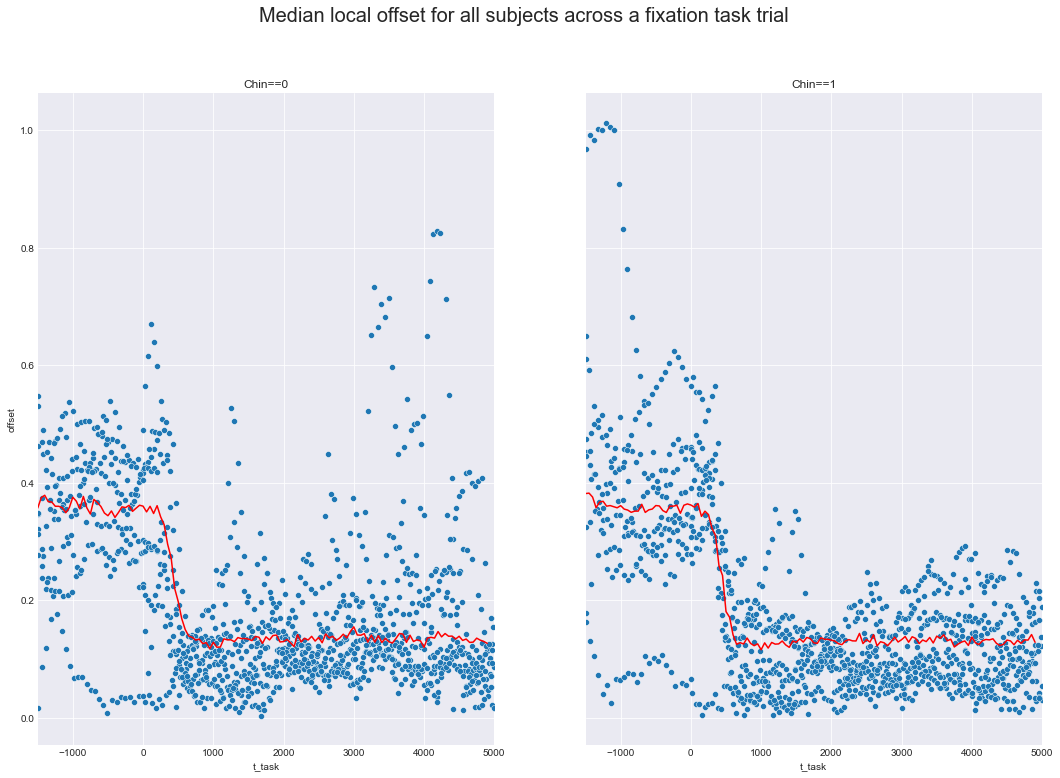

In [101]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Aggregate on trial level

In [102]:
def merge_varMean_by_index(data, data_et, varName):
    if varName in data.columns: 
        data = data.drop(columns=[varName])
    grouped = data_et.groupby(['run_id', 'trial_index'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial = merge_varMean_by_index(data_trial, data_et, 'offset')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset')
data_trial = merge_varMean_by_index(data_trial, data_et, 'offset_px')
data_trial_fix = merge_varMean_by_index(data_trial_fix, data_et_fix, 'offset_px')

## Offset across trials

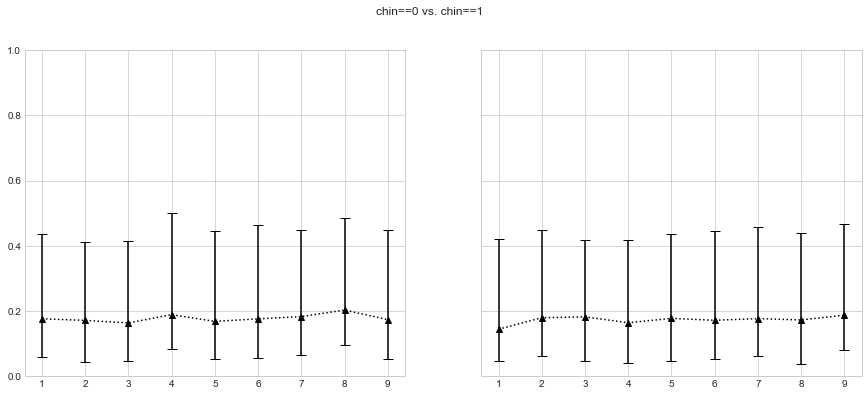

In [222]:
def group_chin_withinTaskIndex(data, varName):
    df_m = data.groupby(['chin', 'withinTaskIndex']) \
        [varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_median'}) \
        .reset_index()

    data = data.merge(df_m, on=['chin', 'withinTaskIndex'], how='left')
    data['above_median'] = data[varName] > data[varName + '_median']
    
    df_std_upper = data.loc[data['above_median']==1, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_upper'}) \
        .reset_index()
    df_std_lower = data.loc[data['above_median']==0, :] \
        .groupby(['chin', 'withinTaskIndex'])[varName].median() \
        .reset_index() \
        .rename(columns={varName: varName + '_std_lower'}) \
        .reset_index()

    output = pd.concat([
        df_m, 
        df_std_upper[varName + '_std_upper'],
        df_std_lower[varName + '_std_lower']
    ], axis=1)
    return output


data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'offset'
)

plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['offset_median'],
        yerr=[data['offset_std_lower'], data['offset_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Aggregate on subject-level 

In [32]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')
data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset_px')

In [33]:
def separate_outcomes_by_condition(data, large_data, varName, varCondition):
    var_cond_0 = varName + '_' + varCondition + '_0' 
    var_cond_1 = varName + '_' + varCondition + '_1' 
    
    if var_cond_0 in data.columns: 
        data = data.drop(columns=[var_cond_0])
    if var_cond_1 in data.columns: 
        data = data.drop(columns=[var_cond_1])
        
    grouped = large_data \
        .groupby(['run_id', varCondition])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns=varCondition, values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_cond_0, 1.0: var_cond_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_cond_0, var_cond_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'chin')

data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'offset', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'offset', 'offset_chin_0', 'offset_chin_1',
        'offset_glasses_binary_0', 'offset_glasses_binary_1'
    ]
].describe()

,offset,offset_chin_0,offset_chin_1,offset_glasses_binary_0,offset_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,0.189287,0.187336,0.190088,0.186347,0.198186
std,0.137479,0.146220,0.137603,0.158221,0.101560
min,0.074473,0.069502,0.058736,0.077386,0.074473
25%,0.105193,0.091033,0.103886,0.105466,0.100085
50%,0.145358,0.145691,0.145555,0.143643,0.194038
75%,0.214305,0.223869,0.249133,0.203550,0.261406
max,0.803767,0.802738,0.804795,0.803767,0.410388


In [34]:
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'chin')
data_subject = separate_outcomes_by_condition(data_subject, data_trial_fix, 'offset_px', 'glasses_binary')

data_subject.loc[
    :, 
    [
        'offset_px', 'offset_px_chin_0', 'offset_px_chin_1',
        'offset_px_glasses_binary_0', 'offset_px_glasses_binary_1'
    ]
].describe()

,offset_px,offset_px_chin_0,offset_px_chin_1,offset_px_glasses_binary_0,offset_px_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,223.296746,222.696675,222.633321,215.395420,243.730015
std,158.617168,174.027103,158.607643,169.646149,144.899037
min,83.776446,60.291561,67.162307,83.776446,84.165071
25%,120.951179,112.699178,123.591381,114.505042,140.725287
50%,174.150998,170.132077,182.185218,167.087227,232.007817
75%,263.363737,261.879914,249.786303,244.716665,295.796382
max,847.848319,848.289765,847.406873,847.848319,632.730659


## Grand mean offset

In [35]:
grouped = data_et_fix.groupby(['run_id', 'trial_index']) \
    ['x', 'y'].mean() \
    .reset_index() \
    .rename(columns={'x': 'x_mean', 'y': 'y_mean'})

if 'x_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['x_mean'])
if 'y_mean' in data_trial_fix.columns:
    data_trial_fix = data_trial_fix.drop(columns=['y_mean'])    
data_trial_fix = data_trial_fix.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
) 
data_trial_fix['x_mean_px'] = data_trial_fix['x_mean'] * data_trial_fix['window_width']
data_trial_fix['y_mean_px'] = data_trial_fix['y_mean'] * data_trial_fix['window_height']
data_trial_fix.loc[:, ['x_mean', 'x_mean_px', 'y_mean', 'y_mean_px']].describe()

<ipython-input-35-066a389a9d25>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data_et_fix.groupby(['run_id', 'trial_index']) \


,x_mean,x_mean_px,y_mean,y_mean_px
count,840.000000,840.000000,840.000000,840.000000
mean,0.497557,796.970179,0.488711,444.748805
std,0.229562,404.147100,0.205357,207.930898
min,-0.128611,-175.682599,-0.119299,-128.842889
25%,0.301174,492.235749,0.344789,296.229328
50%,0.507159,777.118862,0.501852,432.181338
75%,0.694638,1049.862338,0.640276,584.041295
max,1.032567,2282.275511,0.993750,1126.277549


In [36]:
data_trial_fix['grand_deviation'] = euclideanDistance(
    data_trial_fix['x_mean'], data_trial_fix['x_pos'],
    data_trial_fix['y_mean'], data_trial_fix['y_pos']
)
data_trial_fix['grand_deviation'].describe()

count    840.000000
mean       0.177910
std        0.168080
min        0.003546
25%        0.068847
50%        0.125714
75%        0.227849
max        1.285896
Name: grand_deviation, dtype: float64

# Precision

## Distance from AVG on et-level

In [160]:
def merge_xy_means(data):    
    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG_square(data):
    data = merge_xy_means(data)
    data['distanceFromAVG_square'] = np.power(
        euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean']),
        2
    )
    data['distanceFromAVG_square_px'] = np.power(euclideanDistance(
        (data['x'] * data_et['window_width']), 
        (data['x_mean'] * data_et['window_width']), 
        (data['y'] * data_et['window_height']), 
        (data['y_mean'] * data_et['window_height'])
    ), 2)
    
    return(data)  

data_et = distanceFromAVG_square(data_et)
data_et_fix = distanceFromAVG_square(data_et_fix)
print(data_et_fix.loc[
    pd.isna(data_et_fix['distanceFromAVG_square']), 
    ['x', 'y', 'x_pos', 'y_pos', 'distanceFromAVG_square']
])
data_et_fix.loc[
    :, ['distanceFromAVG_square', 'distanceFromAVG_square_px']] \
    .describe()

<ipython-input-160-ca53af98e2a3>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \


Empty DataFrame
Columns: [x, y, x_pos, y_pos, distanceFromAVG_square]
Index: []


,distanceFromAVG_square,distanceFromAVG_square_px
count,6.343200e+04,6.343200e+04
mean,1.126595e-02,1.222609e+04
std,7.706853e-02,7.170556e+04
min,1.540744e-32,1.292470e-26
25%,8.329246e-04,9.223250e+02
50%,2.680577e-03,3.005958e+03
75%,7.431647e-03,8.552995e+03
max,7.604748e+00,6.002216e+06


## Aggregate standard deviation on trial-level

In [161]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square')
data_trial['precision'] = np.sqrt(data_trial['distanceFromAVG_square'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square')
data_trial_fix['precision'] = np.sqrt(data_trial_fix['distanceFromAVG_square'])
print(data_trial_fix['precision'].describe())

count    8.400000e+02
mean     8.458967e-02
std      7.297859e-02
min      1.570092e-16
25%      4.947744e-02
50%      6.701803e-02
75%      9.467478e-02
max      7.483324e-01
Name: precision, dtype: float64


In pixel

In [162]:
data_trial = merge_varMean_by_index(
    data_trial, data_et, 'distanceFromAVG_square_px')
data_trial['precision_px'] = np.sqrt(data_trial['distanceFromAVG_square_px'])

data_trial_fix = merge_varMean_by_index(
    data_trial_fix, data_et_fix, 'distanceFromAVG_square_px')
data_trial_fix['precision_px'] = np.sqrt(data_trial_fix['distanceFromAVG_square_px'])
print(data_trial_fix['precision_px'].describe())

count    8.400000e+02
mean     8.978418e+01
std      7.574351e+01
min      1.607775e-13
25%      5.235842e+01
50%      7.050979e+01
75%      1.043063e+02
max      6.896491e+02
Name: precision_px, dtype: float64


Any missing values?

In [163]:
data_trial_fix.loc[
    pd.isna(data_trial_fix['precision']), 
    ['run_id', 'trial_index', 'x_pos', 'y_pos', 'precision']
]

,run_id,trial_index,x_pos,y_pos,precision
288,38,106.0,0.2,0.8,NaN
289,38,109.0,0.5,0.5,NaN
290,38,112.0,0.8,0.5,NaN
291,38,115.0,0.2,0.5,NaN
292,38,118.0,0.5,0.2,NaN
...,...,...,...,...,...
786,98,246.0,0.2,0.8,NaN
787,98,249.0,0.2,0.5,NaN
788,98,252.0,0.5,0.5,NaN
789,98,255.0,0.5,0.8,NaN


## Precision across trials

In [199]:
data_plot = group_chin_withinTaskIndex(
    data_trial.loc[data_trial['fixTask']==1, :],
    'precision'
)
data_plot

,index,chin,withinTaskIndex,precision_mean,precision_std_upper,precision_std_lower
0,0,0.0,1.0,0.130206,0.195704,0.092496
1,1,0.0,2.0,0.120299,0.187448,0.078331
2,2,0.0,3.0,0.122510,0.217387,0.084047
3,3,0.0,4.0,0.120103,0.168937,0.084291
4,4,0.0,5.0,0.135055,0.224795,0.095170
5,5,0.0,6.0,0.119122,0.162745,0.078730
6,6,0.0,7.0,0.113807,0.173567,0.073324
7,7,0.0,8.0,0.128860,0.198751,0.085179
8,8,0.0,9.0,0.116332,0.167242,0.081845
9,9,1.0,1.0,0.110912,0.157448,0.074004


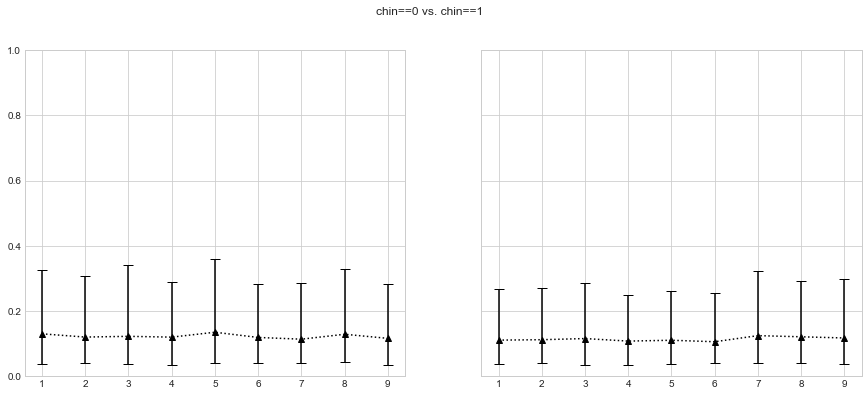

In [200]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chin==0 vs. chin==1')

ax[0].set_ylim(0, 1)

for i in [0, 1]:
    data = data_plot.loc[data_plot['chin']==i, :]
    ax[i].errorbar(
        x = data['withinTaskIndex'], 
        y = data['precision_mean'],
        yerr=[data['precision_std_lower'], data['precision_std_upper']],
        fmt='^k:',
        capsize=5
    )
plt.show()

## Aggregate on subject-level 

In [41]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision', 'precision_chin_0', 'precision_chin_1',
        'precision_glasses_binary_0', 'precision_glasses_binary_1'
    ]
].describe()

,precision,precision_chin_0,precision_chin_1,precision_glasses_binary_0,precision_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,0.083325,0.086388,0.079449,0.080702,0.088290
std,0.051085,0.056255,0.049525,0.053549,0.049799
min,0.003469,0.004836,0.002101,0.045034,0.003469
25%,0.058795,0.063243,0.054928,0.055661,0.067032
50%,0.073681,0.075681,0.067942,0.067442,0.077988
75%,0.089642,0.088269,0.086965,0.087535,0.093848
max,0.329039,0.397298,0.255742,0.329039,0.215294


In pixel

In [42]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision_px')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'chin')
data_subject = separate_outcomes_by_condition(
    data_subject, data_trial_fix, 'precision_px', 'glasses_binary')
data_subject.loc[
    :, 
    [
        'precision_px', 'precision_px_chin_0', 'precision_px_chin_1',
        'precision_px_glasses_binary_0', 'precision_px_glasses_binary_1'
    ]
].describe()

,precision_px,precision_px_chin_0,precision_px_chin_1,precision_px_glasses_binary_0,precision_px_glasses_binary_1
count,42.000000,42.000000,42.000000,26.000000,15.000000
mean,89.629667,93.279790,84.928375,88.237987,91.764393
std,55.476888,64.531505,48.913992,59.539102,51.704125
min,3.147347,4.088138,2.206555,44.462601,3.147347
25%,63.418369,66.594180,59.675956,62.435341,68.559871
50%,76.989729,77.618063,77.203768,75.758447,86.491603
75%,97.326981,102.647655,96.520536,95.342957,95.536576
max,358.237167,446.535285,252.198697,358.237167,204.153740


# Main effect: chin-rest
 - t-tests will follow
 - TODO: Compare subjects with high fps (Semmelmann & Weigelt, 2019)

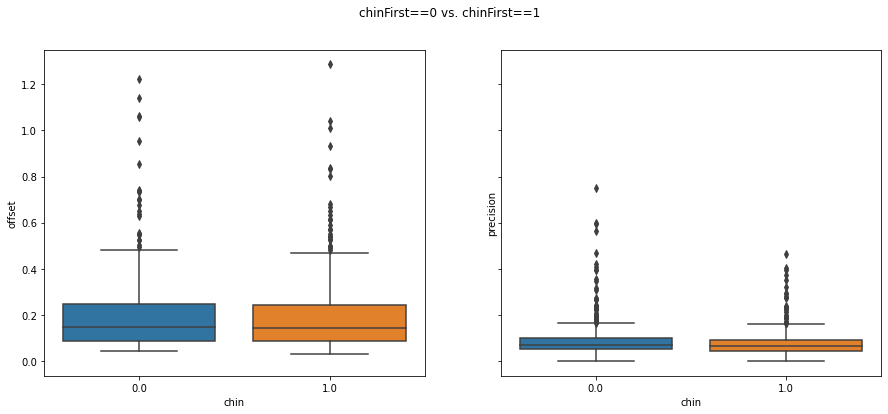

In [43]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

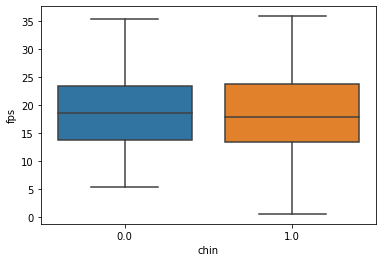

In [44]:
sns.boxplot(x='chin', y='fps', data=data_trial_fix)   
plt.show()

In [45]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.187336,0.021380
1,offset_chin_1,0.190088,0.018935
2,precision_chin_0,0.086388,0.003165
3,precision_chin_1,0.079449,0.002453


In [46]:
test_data = data_subject.loc[
    pd.notna(data_subject['offset_chin_0']) & 
    pd.notna(data_subject['offset_chin_1']), :]
scipy.stats.ttest_rel(test_data['offset_chin_0'], test_data['offset_chin_1'])

Ttest_relResult(statistic=-0.21884454358289437, pvalue=0.8278569152750408)

## Data quality across chinFirst condition

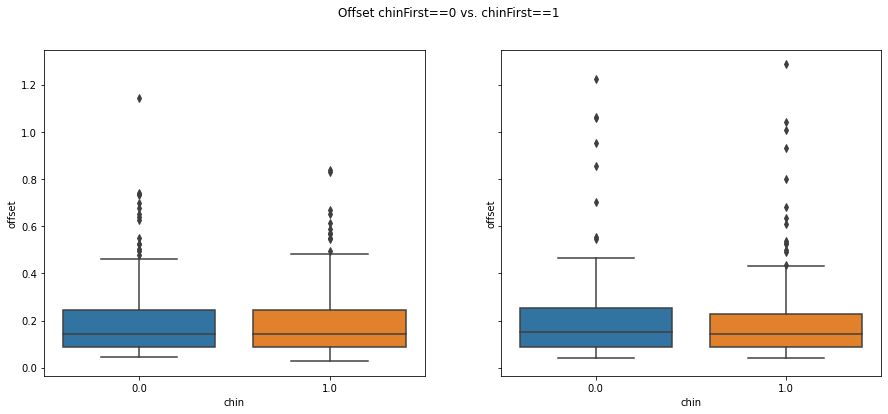

In [47]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

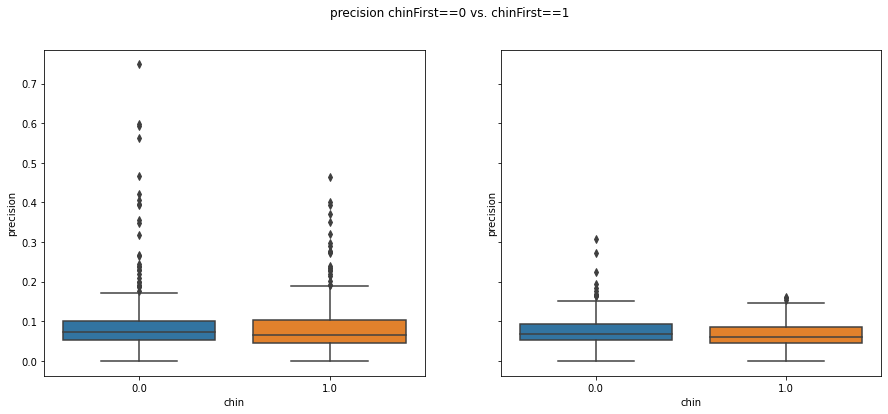

In [48]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

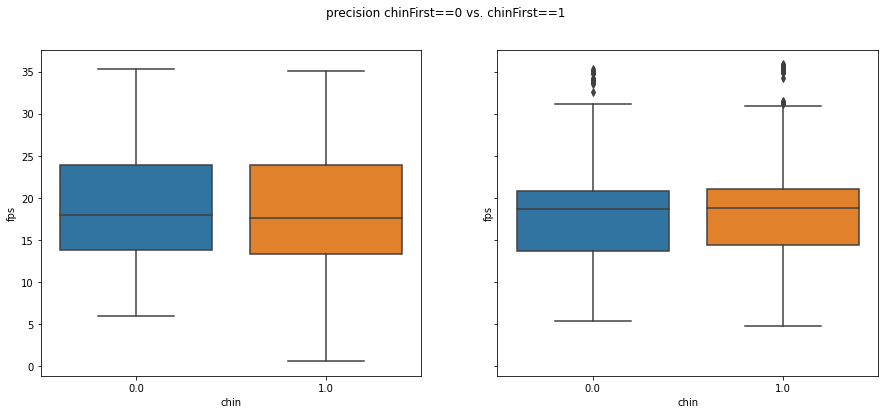

In [49]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='fps', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

## Offset & precision across fixation dot positions

In [50]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.198835
offset_chin_1           0.194276
offset_var_chin_0       0.028109
offset_var_chin_1       0.026603
precision_chin_0        0.091189
precision_chin_1        0.078019
precision_var_chin_0    0.006890
precision_var_chin_1    0.003763
dtype: float64


<ipython-input-50-15d38b239ff3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
<ipython-input-50-15d38b239ff3>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.204469,0.194078,0.017780,0.014563,0.102263,0.084346,0.007779,0.003355
1,1,0.192806,0.179691,0.017534,0.013254,0.092087,0.079710,0.006197,0.003250
2,2,0.248520,0.193680,0.049705,0.023718,0.111304,0.085345,0.011954,0.002174
3,3,0.180222,0.180257,0.017465,0.017474,0.089266,0.083205,0.008429,0.004710
4,4,0.147181,0.140737,0.016623,0.013123,0.081734,0.068208,0.004337,0.002848
5,5,0.173969,0.197265,0.028475,0.033457,0.083296,0.074971,0.003118,0.002518
6,6,0.228612,0.245055,0.028775,0.035813,0.087875,0.080279,0.004682,0.005263
7,7,0.179317,0.192284,0.029990,0.037003,0.077163,0.072926,0.004212,0.005125
8,8,0.234421,0.225439,0.046636,0.051021,0.095709,0.073184,0.011301,0.004622


# Main effect: Visual Aid

## Frequency of visual aids

In [52]:
data_subject['glasses_binary'] = data_subject['sight'] \
    .replace({'contactLenses': 1, 
             'glasses': 1,
             'notCorrected': 0,
             'perfectSight': 0}
           )
data_subject['glasses_binary'].unique()

array([ 1.,  0., nan])

In [237]:
for col in ['glasses', 'sight', 'glasses_binary']:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0         count
glasses            
longSight         7
noCorrection     29
progressive       1
shortSight       13


col_0          count
sight               
contactLenses      3
glasses           17
notCorrected       1
perfectSight      29


col_0           count
glasses_binary       
0.0                30
1.0                20




## offset & precision on subject-level

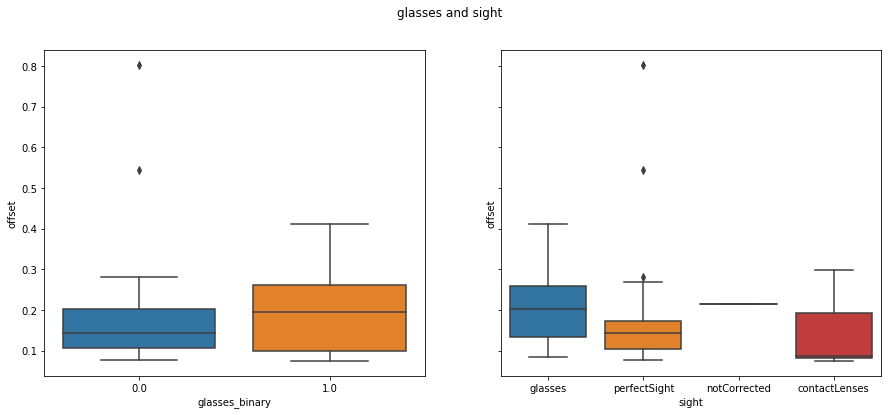

In [53]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='offset', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='offset', data=data_subject)
   
plt.show()

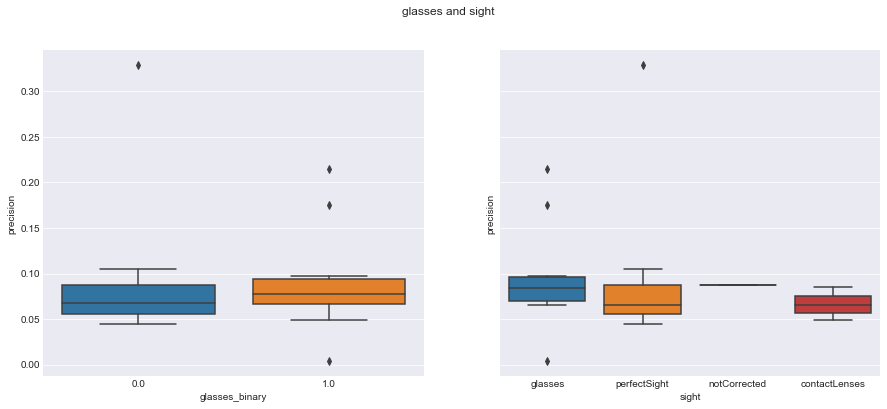

In [236]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('glasses and sight')

sns.boxplot(ax=axes[0], x='glasses_binary', y='precision', data=data_subject)
sns.boxplot(ax=axes[1], x='sight', y='precision', data=data_subject)
   
plt.show()

# Gaze predictions

## Gaze dot positions for each position

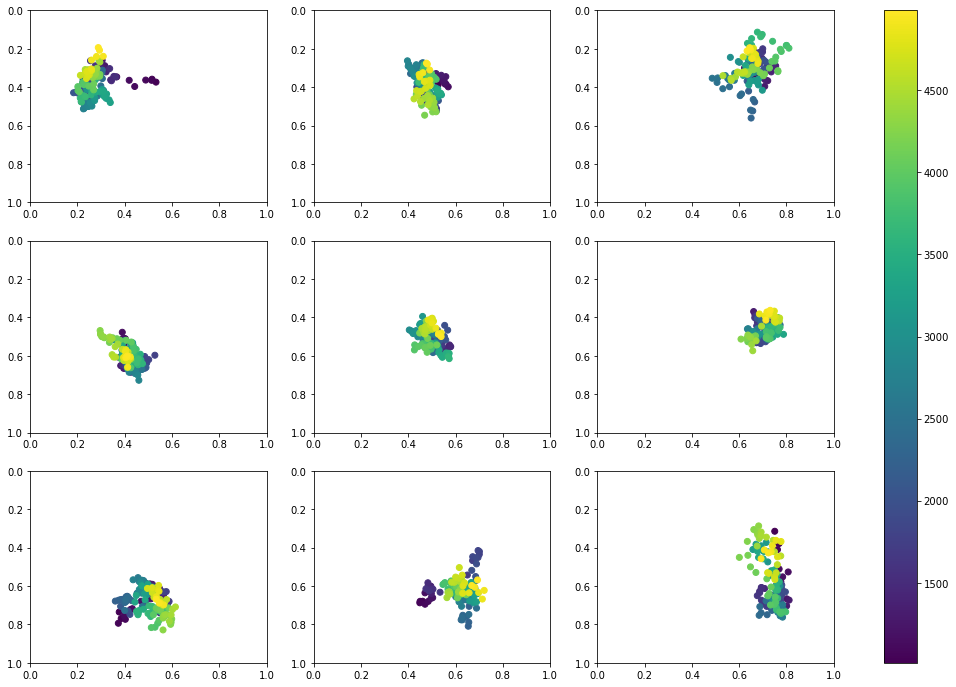

In [55]:
data_plot = add_var_to_data_et(data_et_fix, data_trial, 'chin')
data_plot = data_plot.loc[
    (data_plot['run_id']==43) & 
    (data_plot['chin']==0), :]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[(data_plot['x_pos']==xPos[i]) & (data_plot['y_pos']==yPos[i]), :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

## Heatmap

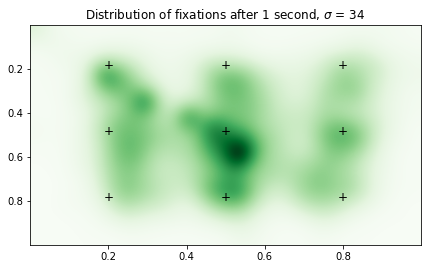

<Figure size 432x288 with 0 Axes>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter

x = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'x']

y = data_et_fix.loc[
    (data_et_fix['x']>0) & (data_et_fix['x']<1) &
    (data_et_fix['y']>0) & (data_et_fix['y']<1),
    'y']

def myplot(x, y, s, bins=[1200, 675]):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    extent = [xedges[0], xedges[-1], yedges[-1], yedges[0]]
    return heatmap.T, extent

s=34
img, extent = myplot(x, y, s=s)

plt.figure(figsize=(7, 7))
plt.imshow(img, extent=extent, origin='upper', cmap=cm.Greens, aspect=(9/16))
plt.title("Distribution of fixations after 1 second, $\sigma$ = %d" % s)


xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, len(xPos)):
    plt.text(xPos[i], yPos[i], '+', size=12, ha="center")

plt.show()
plt.savefig('plots/fix_heatmap.png')

# Additional analyis

## Median offset across calibration trials
Does data quality improve during calibration? 

In [233]:
data_et_calibration = data_et.loc[data_et['trial_type']=='eyetracking-calibration', :]
data_trial_calibration = data_trial \
    .loc[data_trial['trial_type']=='eyetracking-calibration', :]

# Add median offset 
grouped = data_et_calibration \
    .groupby(['run_id', 'trial_index'])['offset'].median() \
    .reset_index() \
    .rename(columns={'offset': 'offset_median'}) 
data_trial_calibration = data_trial_calibration.merge(
    grouped,
    on=['run_id', 'trial_index'],
    how='left'
)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


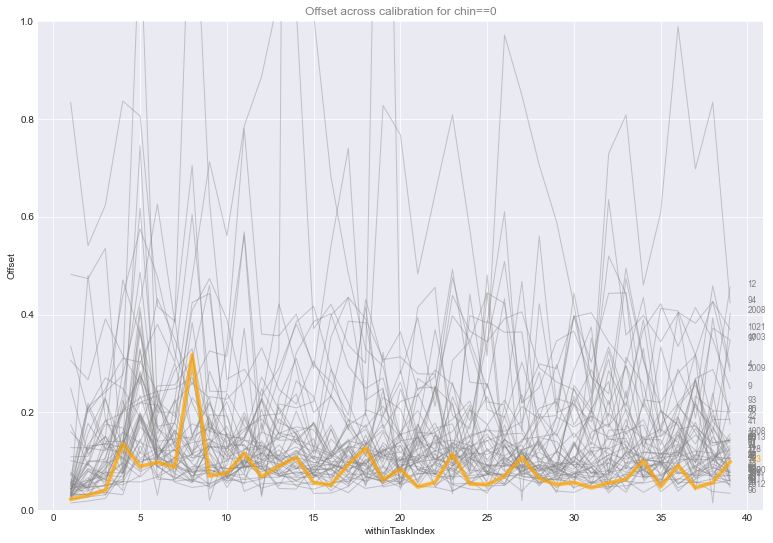

In [234]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(13, 9))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


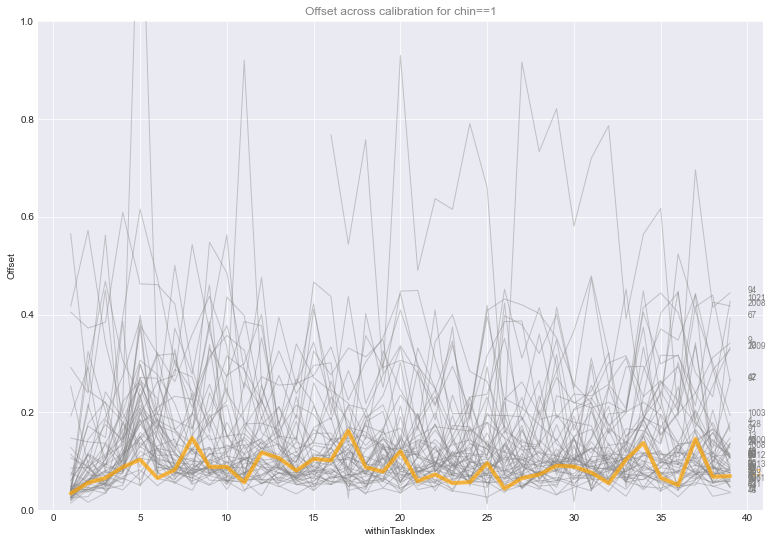

In [235]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset_median', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

## Median precision across calibration trials

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


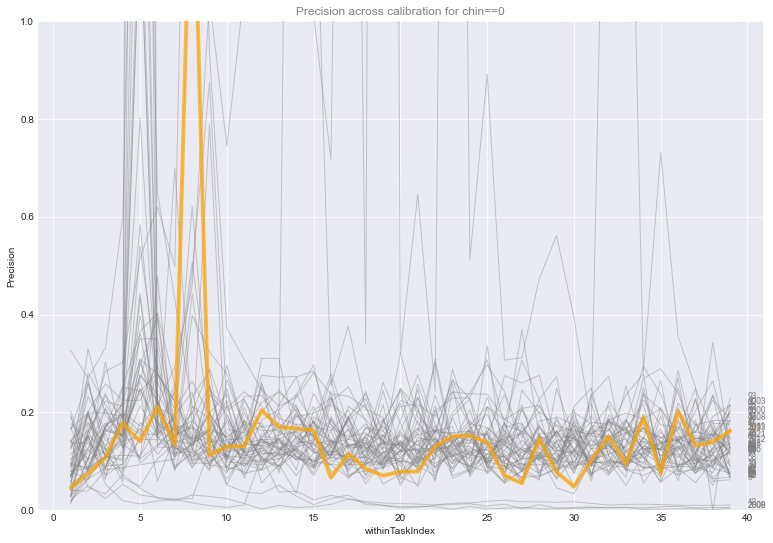

In [60]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


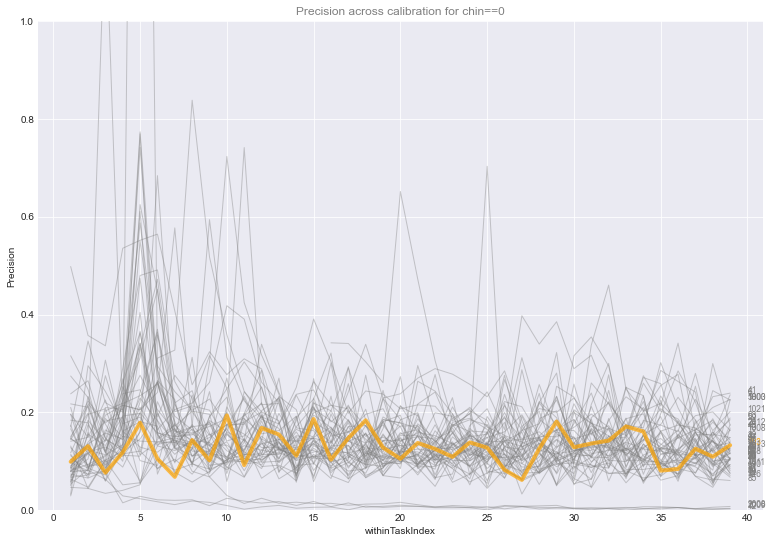

In [61]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## Categorical confounders

In [257]:
predictors = [
    'chinFirst', 'vertPosition', 'gender', 'ethnic',  
    'degree', 'browser', 'glasses', 'sight']  
for col in predictors:
    print(pd.crosstab(index=data_subject[col], columns="count"))
    print('\n')

col_0      count
chinFirst       
0.0           26
1.0           25


col_0         count
vertPosition       
a                18
b                24
c                 8


col_0    count
gender        
diverse      1
female      16
male        33


col_0      count
ethnic          
asian          2
black          3
caucasian     41
hispanic       4


col_0       count
degree           
college        18
grad           10
highSchool     13
middle          3


col_0    count
browser       
Chrome      52
Edge         2
Firefox      7
Opera        2
Safari      10


col_0         count
glasses            
longSight         7
noCorrection     29
progressive       1
shortSight       13


col_0          count
sight               
contactLenses      3
glasses           17
notCorrected       1
perfectSight      29




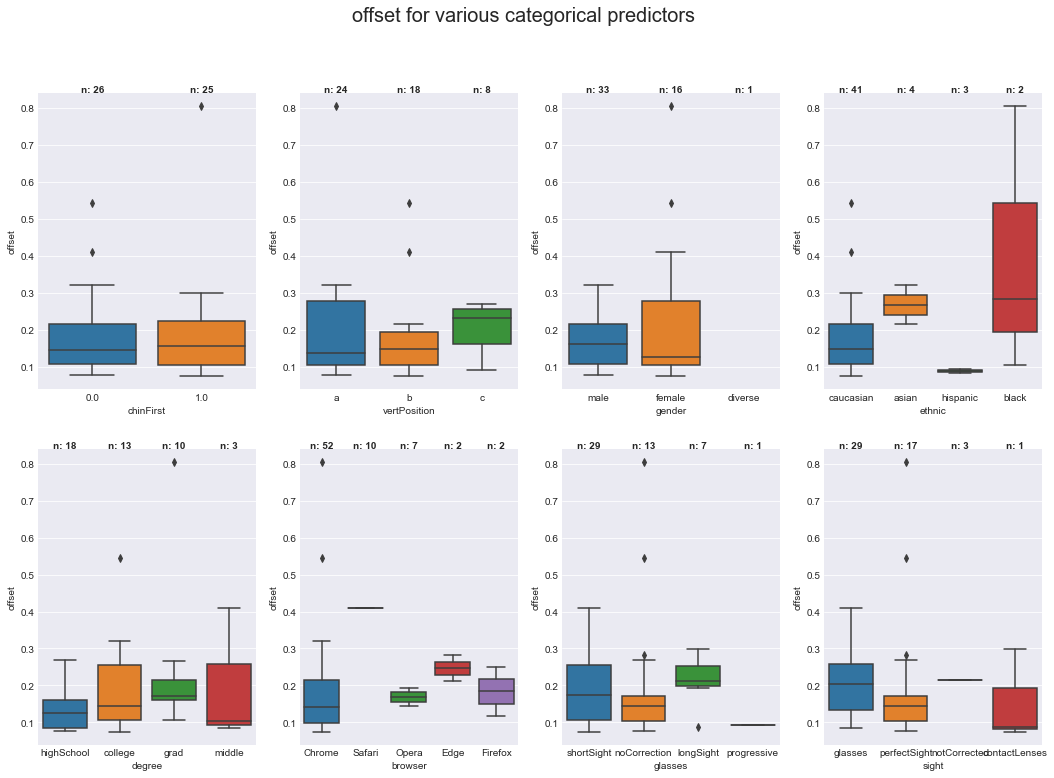

In [300]:
def getBoxPlots(outcome, yPos):
    fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18, 12))
    fig.suptitle(outcome + ' for various categorical predictors', fontsize=20)
    ax = ax.ravel()
    for i in range(0, 8):
        sns.boxplot(ax=ax[i], x=predictors[i], y=outcome, data=data_subject)
        nobs = data_subject[predictors[i]].value_counts().values
        nobs = [str(x) for x in nobs.tolist()]
        nobs = ["n: " + i for i in nobs]
        # Add it to the plot
        pos = range(len(nobs))
        for tick,label in zip(pos,ax[i].get_xticklabels()):
            ax[i].text(pos[tick], yPos, nobs[tick], # medians[tick] + 0.02
            verticalalignment='top',
            horizontalalignment='center', size='medium', weight='semibold')
            
getBoxPlots('offset', 0.86)

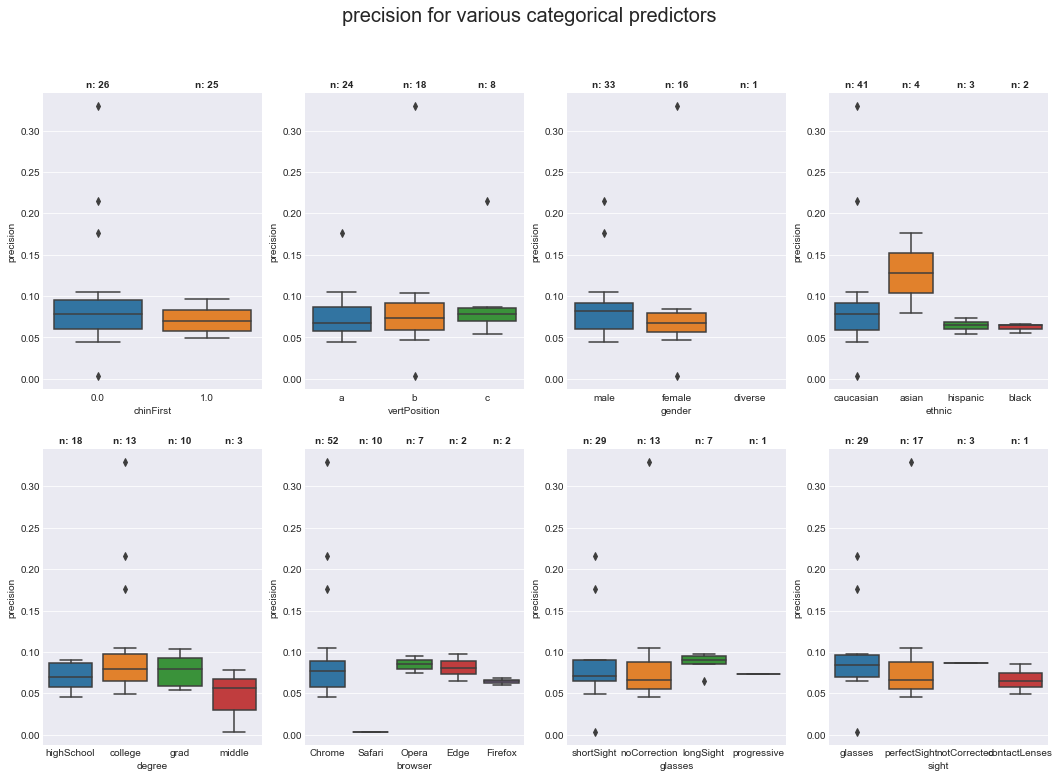

In [306]:
getBoxPlots('precision', yPos=0.36)

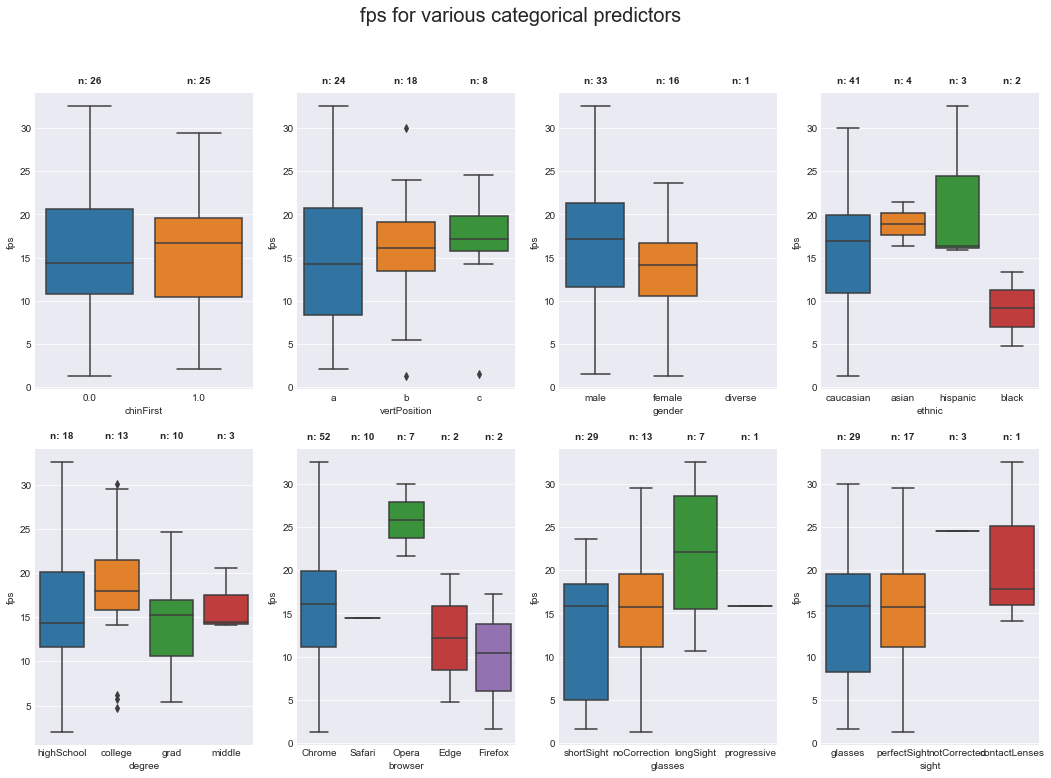

In [305]:
getBoxPlots('fps', yPos=36)

## Correlation Plot

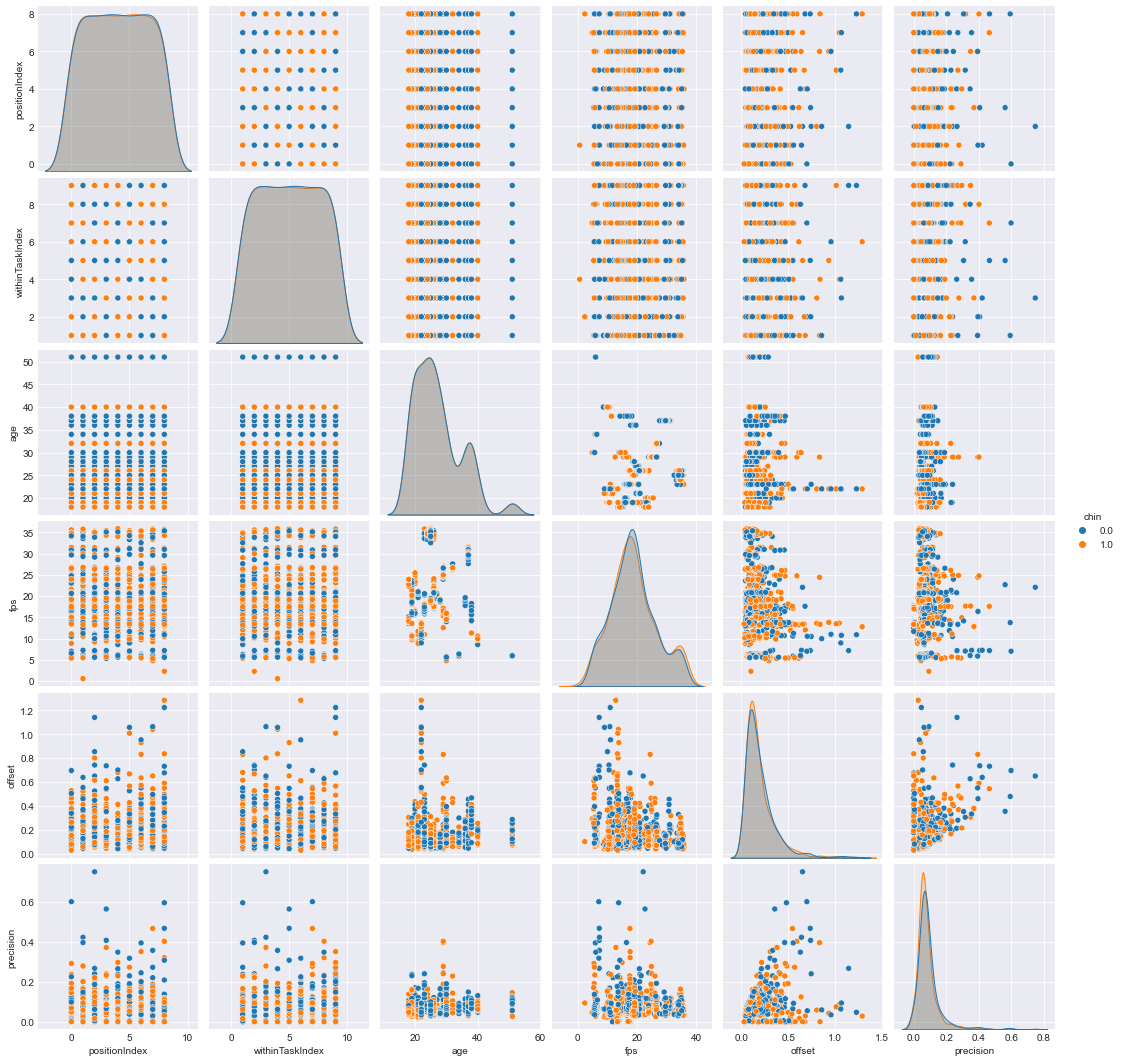

In [65]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

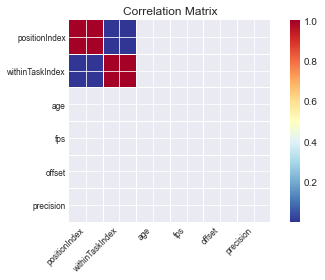

In [66]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [67]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,
withinTaskIndex,0.001,-,,,,
age,-0.004,0.002,-,***,,*
fps,-0.003,-0.004,-0.148,-,***,
offset,0.041,0.008,0.008,-0.255,-,***
precision,-0.061,0.005,0.09,-0.066,0.301,-


In [68]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,929,754,841,840,840
withinTaskIndex,0.001,-,754,841,840,840
age,-0.004,0.002,-,666,666,666
fps,-0.003,-0.004,-0.148,-,840,840
offset,0.041,0.008,0.008,-0.255,-,840
precision,-0.061,0.005,0.09,-0.066,0.301,-


# MLA Model

In [69]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = model.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: precision
No. Observations: 840     Method:             REML     
No. Groups:       47      Scale:              0.0021   
Min. group size:  15      Log-Likelihood:     1317.3455
Max. group size:  18      Converged:          Yes      
Mean group size:  17.9                                 
--------------------------------------------------------
           Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------
Intercept  0.085     0.009  9.051  0.000   0.067   0.104
x_pos      0.000     0.006  0.060  0.952  -0.012   0.013
Group Var  0.004     0.017                              



C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2168: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


# Export

In [70]:
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)

data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)

data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [71]:
print('Success! Script ran through')

Success! Script ran through
